# Geberation Results

The goal of this notebook is to compare the text generations when using the traditional RAG and when usign the re-ranking with datamodels


In [23]:
import os
import random
import numpy as np
import torch

import json
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from dmcr.evaluators.Rouge_L_evaluator import Rouge_L_evaluator

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
seed = 42

torch.backends.cudnn.enabled = False
# NumPy
np.random.seed(seed)
random.seed(seed)
# PyTorch
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



if torch.cuda.is_available():
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Number of GPUs available: 1
GPU 0: NVIDIA RTX A5000


## Load Data

In [24]:
GENERATIONS_PATH = "generations"
rag_generations = json.load(open(f"{GENERATIONS_PATH}/rag_generations.json"))
datamodels_generations = json.load(open(f"{GENERATIONS_PATH}/datamodels_generations.json"))

In [25]:
questions = pl.read_ipc("../50_test.feather")

In [31]:
weights = torch.load("datamodels/models/preview_50_L2/weights.pt")
evaluation = pl.read_ipc("datamodels/evaluations/evaluation_preview_50_L2_mse.feather")
evaluation_R2 = pl.read_ipc("datamodels/evaluations/evaluation_preview_50_L2_R2Score.feather")

/tmp/ipykernel_3351872/2531353506.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("datamodels/models/preview_50_L2/weights.pt")


## Evaluations Datamodels

In [33]:
print(f"Mean MSe: {evaluation.select('metric_mse').mean()}")
print(f"Median MSE: {evaluation.select('metric_mse').median()}")

Mean MSe: shape: (1, 1)
┌────────────┐
│ metric_mse │
│ ---        │
│ f64        │
╞════════════╡
│ 0.004715   │
└────────────┘
Median MSE: shape: (1, 1)
┌────────────┐
│ metric_mse │
│ ---        │
│ f64        │
╞════════════╡
│ 0.000059   │
└────────────┘


<Axes: xlabel='metric_mse', ylabel='Count'>

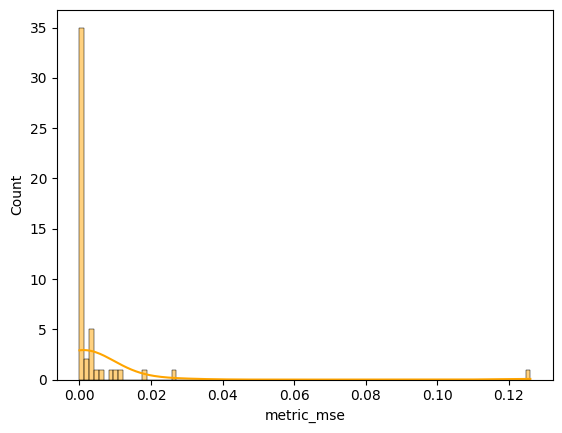

In [34]:
sns.histplot(
    data=evaluation,
    x="metric_mse",
    kde=True,
    color="orange"
)

In [36]:
print(f"Mean R2: {evaluation_R2.select('metric_R2Score').mean()}")
print(f"Median R2: {evaluation_R2.select('metric_R2Score').median()}")

Mean R2: shape: (1, 1)
┌────────────────┐
│ metric_R2Score │
│ ---            │
│ f64            │
╞════════════════╡
│ -inf           │
└────────────────┘
Median R2: shape: (1, 1)
┌────────────────┐
│ metric_R2Score │
│ ---            │
│ f64            │
╞════════════════╡
│ -inf           │
└────────────────┘


In [37]:
evaluation_R2

metric_R2Score,test_idx
f64,i64
-inf,0
-1.151525,1
-inf,2
-inf,3
-0.219454,4
…,…
-1.292655,45
-inf,46
-inf,47


In [38]:
from dmcr.datamodels.models import LinearRegressor

DATAMODELS_PATH = "datamodels"
model_id = "preview_50_L2"
num_models = 50
metric = "R2Score"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Load model parameters
weigths = torch.load(f"{DATAMODELS_PATH}/models/{model_id}/weights.pt", weights_only=True)
bias = torch.load(f"{DATAMODELS_PATH}/models/{model_id}/bias.pt", weights_only=True)

## Create and verify list of files from collection
colleciton_path = f"{DATAMODELS_PATH}/collections/test/"
collections_arr = [os.path.join(colleciton_path, f) for f in os.listdir(colleciton_path) if f.endswith(".feather")]
if len(collections_arr) == 0:
    raise Exception("No collections found in test folder")

df = pl.concat([pl.read_ipc(file) for file in collections_arr], how="vertical")



evaluations = {
    f"metric_{metric}": [],
    "test_idx": [],
}


for idx in range(1):
        
        print(f"Model {idx} under evaluation")

        ## Preoare dataset
        
        _temp = (
            df.filter(pl.col("test_idx") == idx)
            .select(pl.col("input"), pl.col("evaluation"))
        )

        _x = _temp["input"].to_numpy()
        _y = _temp["evaluation"].to_numpy()

        dataset = torch.utils.data.TensorDataset(torch.tensor(_x, device=device), torch.tensor(_y, device=device))
        test_loader = torch.utils.data.DataLoader(dataset, batch_size=len(_x))

        ## Load models
        model = LinearRegressor(len(dataset[0][0]), 1)
        model.load_state_dict({ "linear.weight": weigths[idx].unsqueeze(0), "linear.bias": bias[idx].unsqueeze(0) })
        model.to(device)

        ## Evaluate in test
        inputs, target = next(iter(test_loader))

        total_metric = model.evaluate(inputs.to(device).to(dtype=torch.float32), target.to(device).to(dtype=torch.float32), metric=metric)

        evaluations[f"metric_{metric}"].append(total_metric)
        evaluations["test_idx"].append(idx)


## Save evaluations
if not os.path.exists(f"{DATAMODELS_PATH}/evaluations"):
    os.mkdir(f"{DATAMODELS_PATH}/evaluations")

test_eval = pl.DataFrame(evaluations)

Model 0 under evaluation


In [44]:
df.filter(pl.col("test_idx") == 4).filter(pl.col("evaluation") > 0)

collection_idx,test_idx,input,evaluation
i64,i64,"array[i64, 100]",f64
64,4,"[0, 0, … 0]",0.285714


In [45]:
colleciton_path = f"{DATAMODELS_PATH}/collections/train/"
collections_arr = [os.path.join(colleciton_path, f) for f in os.listdir(colleciton_path) if f.endswith(".feather")]
if len(collections_arr) == 0:
    raise Exception("No collections found in test folder")

df = pl.concat([pl.read_ipc(file) for file in collections_arr], how="vertical")


In [49]:
df.filter(pl.col("evaluation") > 0)

collection_idx,test_idx,input,evaluation
i64,i64,"array[i64, 100]",f64
1000,20,"[0, 0, … 0]",0.142857
1000,23,"[0, 0, … 0]",0.307692
1000,25,"[0, 0, … 0]",0.181818
1000,26,"[0, 0, … 0]",0.25
1000,45,"[0, 0, … 0]",0.5
…,…,…,…
999,18,"[0, 0, … 0]",0.142857
999,23,"[0, 0, … 0]",0.166667
999,25,"[0, 0, … 0]",0.166667


## Results for Generations Comparison

In [34]:
results = {
    "idx": [],
    "mean_metric_rag": [],
    "mean_metric_datamodels": [],
}
evaluator = Rouge_L_evaluator()


for i in range(len(rag_generations)):
    rag_i_results = []
    datamodels_i_results = []
    results["idx"].append(i)
    for j in range(len(rag_generations[str(i)])):

        max_rag = 0
        max_datamodels = 0
        
        for res in  questions[i]["answers"].to_numpy().flatten()[0]:

            metric_rag = evaluator.evaluate(np.array([res]), np.array([str(rag_generations[str(i)][j])]))
            metric_datamodels = evaluator.evaluate(np.array([res]), np.array([str(datamodels_generations[str(i)][j])]))
            
            max_rag = max(max_rag, metric_rag[0])
            max_datamodels = max(max_datamodels, metric_datamodels[0])

        rag_i_results.append(max_rag)
        datamodels_i_results.append(max_datamodels)

    results["mean_metric_rag"].append(np.mean(rag_i_results))
    results["mean_metric_datamodels"].append(np.mean(datamodels_i_results))
    df_results = pl.DataFrame(results)
    df_results.write_ipc("results.feather")

df_results = pl.DataFrame(results)

In [8]:
rag_generations[str(i)][j]

'According to the Death Penalty Information Center, there are'

In [9]:
np.array([res])

array(['2,718'], dtype='<U5')

In [39]:
results = pl.read_ipc("results.feather")
rag_metric = results["mean_metric_rag"].to_numpy().flatten()
datamodels_metric = results["mean_metric_datamodels"].to_numpy().flatten()

In [43]:
print(np.mean(rag_metric), np.mean(datamodels_metric))

0.05067113997113996 0.05640779220779221
